### Elevation change drived by altimeter 


In [5]:
from utils.geotif_io import readTiff
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import xarray as xr

In [35]:
path_setp_vec = 'data/boundary/setp_zhao2022.gpkg'
path_dem = 'data/dem-data/srtm-c/SRTMGL3_900m.tif'
path_result_isat1 = 'data/icesat-1/result_isat1.nc'
path_result_isat2 = 'data/icesat-2/result_isat2.nc'


In [41]:
dem, dem_info = readTiff(path_dem)
result_isat1_xr = xr.open_dataset(path_result_isat1)
result_isat2_xr = xr.open_dataset(path_result_isat2)
result_isat1_xr
result_isat2_xr


<xarray.Dataset>
Dimensions:                      (tiles_id: 28, bins_id: 50, years: 5)
Coordinates:
  * tiles_id                     (tiles_id) object 'tile_27_96' ... 'tile_31_95'
  * bins_id                      (bins_id) object '2500-2600' ... '7400-7500'
  * years                        (years) object '2018' '2019' ... '2021' '2022'
Data variables: (12/13)
    tiles_lat                    (tiles_id) int64 ...
    tiles_lon                    (tiles_id) int64 ...
    area_glacier_tiles           (tiles_id) float64 ...
    area_glacier_bins            (bins_id) float64 ...
    ele_change_setp_cor          (years) float64 ...
    ele_change_setp_cor_fitting  (years) float64 ...
    ...                           ...
    ele_rate_setp                float64 ...
    ele_rate_setp_error          float64 ...
    ele_rate_tiles               (tiles_id) float64 ...
    ele_rate_tiles_error         (tiles_id) float64 ...
    ele_rate_bins                (bins_id) float64 ...
    ele_rate_bins_error          (bins_id) float64 ...

In [5]:
# years = [str(year) for year in range(2000, 2022)]   ## 


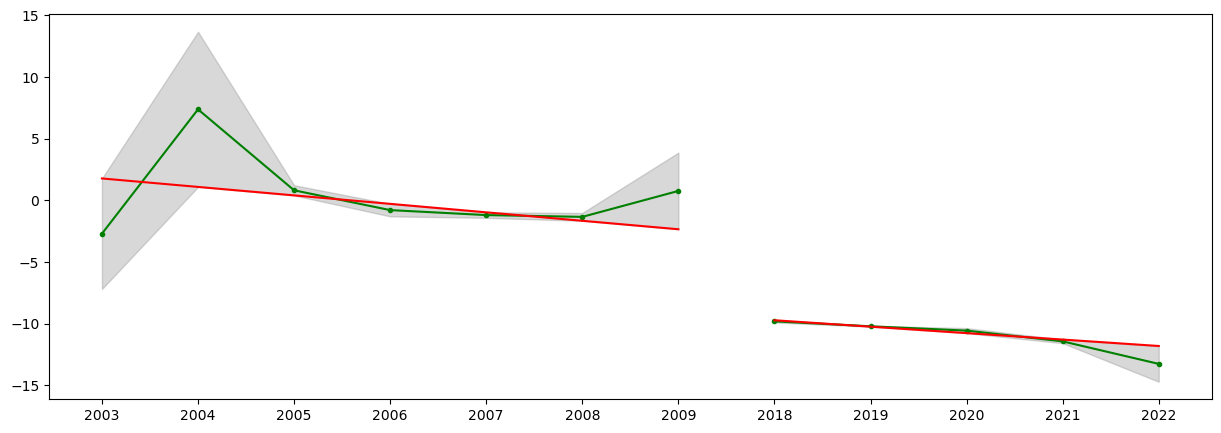

In [45]:
plt.figure(figsize=(15,5))
residual_fit_isat1 = abs(result_isat1_xr['ele_change_setp_cor'].values - result_isat1_xr['ele_change_setp_cor_fitting'].values)
residual_fit_isat2 = abs(result_isat2_xr['ele_change_setp_cor'].values - result_isat2_xr['ele_change_setp_cor_fitting'].values)

#### icesat-1
plt.plot(result_isat1_xr.years, result_isat1_xr['ele_change_setp_cor'], '.-g', label='bins weighting and then tiles weighting')   ### bin-based area weighting -> tile-based area weighting
plt.plot(result_isat1_xr.years, result_isat1_xr['ele_change_setp_cor_fitting'], '-r', label='bins weighting and then tiles weighting')   ### bin-based area weighting -> tile-based area weighting
plt.fill_between(result_isat1_xr.years, result_isat1_xr['ele_change_setp_cor'] - residual_fit_isat1, \
                 result_isat1_xr['ele_change_setp_cor'] + residual_fit_isat1,
                 color='gray', alpha=0.3)

#### icesat-2
plt.plot(result_isat2_xr.years, result_isat2_xr['ele_change_setp_cor'], '.-g', label='bins weighting and then tiles weighting')   ### bin-based area weighting -> tile-based area weighting
plt.plot(result_isat2_xr.years, result_isat2_xr['ele_change_setp_cor_fitting'], '-r', label='bins weighting and then tiles weighting')   ### bin-based area weighting -> tile-based area weighting
plt.fill_between(result_isat2_xr.years, result_isat2_xr['ele_change_setp_cor'] - residual_fit_isat2, \
                 result_isat2_xr['ele_change_setp_cor'] + residual_fit_isat2,
                 color='gray', alpha=0.3)




### Tile-based elevation change mapping

In [48]:
result_isat2_xr

<xarray.Dataset>
Dimensions:                      (tiles_id: 28, bins_id: 50, years: 5)
Coordinates:
  * tiles_id                     (tiles_id) object 'tile_27_96' ... 'tile_31_95'
  * bins_id                      (bins_id) object '2500-2600' ... '7400-7500'
  * years                        (years) object '2018' '2019' ... '2021' '2022'
Data variables: (12/13)
    tiles_lat                    (tiles_id) int64 27 27 27 28 28 ... 31 31 31 31
    tiles_lon                    (tiles_id) int64 96 97 98 94 95 ... 92 93 94 95
    area_glacier_tiles           (tiles_id) float64 ...
    area_glacier_bins            (bins_id) float64 ...
    ele_change_setp_cor          (years) float64 -9.811 -10.21 ... -11.43 -13.26
    ele_change_setp_cor_fitting  (years) float64 -9.722 -10.24 ... -11.29 -11.81
    ...                           ...
    ele_rate_setp                float64 ...
    ele_rate_setp_error          float64 ...
    ele_rate_tiles               (tiles_id) float64 ...
    ele_rate_tiles_error         (tiles_id) float64 ...
    ele_rate_bins                (bins_id) float64 ...
    ele_rate_bins_error          (bins_id) float64 ...

['$\\mathdefault{200}$', '$\\mathdefault{400}$', '$\\mathdefault{600}$']


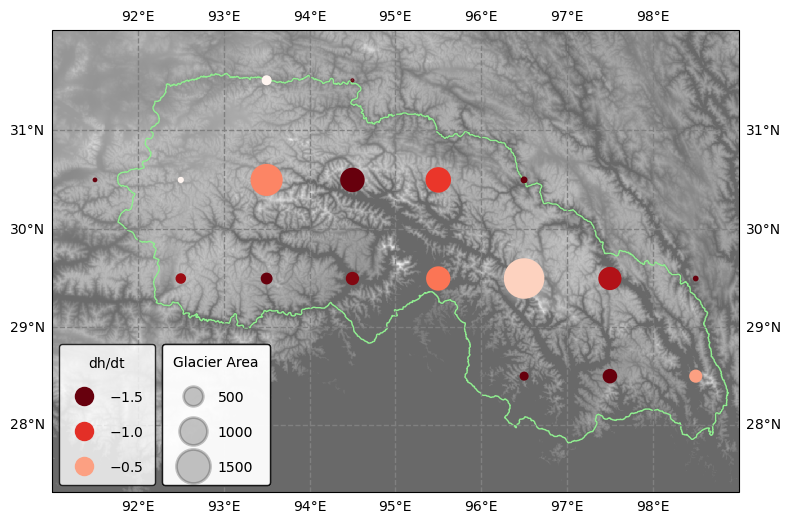

In [51]:
# Scatterplot
cmap_dem = LinearSegmentedColormap.from_list('linear color', ["DimGray", "white"])
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator(central_longitude=88.5))
ax.set_extent([91, 99, 27.3, 32])
ax_dem = ax.imshow(dem, extent=dem_info['geoextent'], 
                                vmin=3500, vmax=7000, cmap=cmap_dem, \
                                transform=ccrs.PlateCarree(), zorder=0)   ## cmap:PRGn

## 1. Tibeteau southeast boundary
shp_fea = cfeature.ShapelyFeature(Reader(path_setp_vec).geometries(), \
                      crs=ccrs.PlateCarree(), edgecolor='lightgreen', linewidth=1, facecolor='none')
ax.add_feature(shp_fea, zorder=0)

cmap_dhdt=plt.cm.get_cmap('Reds').reversed()

scatter = ax.scatter(
    x = result_isat2_xr['tiles_lon'].values+0.5, 
    y = result_isat2_xr['tiles_lat'].values+0.5, 
    s = result_isat2_xr['area_glacier_tiles'].values/2.5,
    c = result_isat2_xr['ele_rate_tiles'].values,
    cmap=cmap_dhdt,
    alpha=1, 
    linewidth=2,
    vmax=0,
    vmin=-1.5,
    transform=ccrs.PlateCarree(),
    )

ax.gridlines(draw_labels=True, linewidth=1, alpha=1, zorder=1, color='grey', linestyle='--')

# produce a legend with the unique colors from the scatter
handles, labels = scatter.legend_elements(prop="colors", num=[-1.5, -1, -0.5])
legend1 = ax.legend(handles, labels, loc="lower left", title="dh/dt",\
                            facecolor='white', edgecolor='black', borderpad=0.8, labelspacing=1.5, markerscale=2)

# produce a legend with a cross-section of sizes from the scatter
handles, labels = scatter.legend_elements(prop="sizes", num=[500/2.5, 1000/2.5, 1500/2.5], alpha=0.2)
print(labels)
legend2 = ax.legend(handles, [500, 1000, 1500], loc="lower left", title="Glacier Area", \
                                                edgecolor='black', borderpad = 0.8, labelspacing=1.5, bbox_to_anchor=(0.15, 0.))

ax.add_artist(legend1)
ax.add_artist(legend2)



### Bin-based elevation change mapping


Text(0.5, 1.0, 'selected tile')

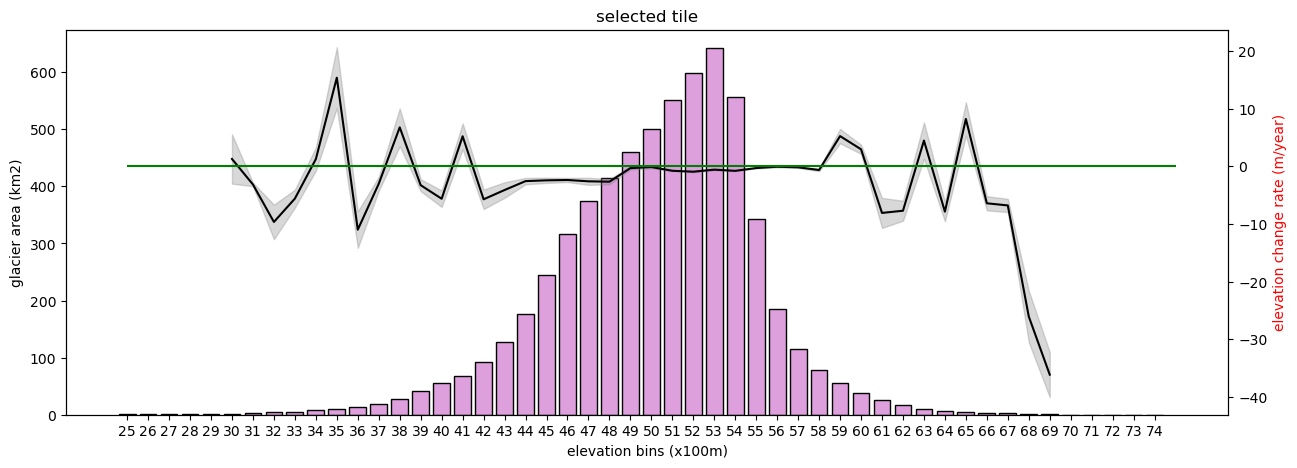

In [54]:
bins_id = result_isat2_xr['bins_id'].values
bins_id_start = [bin_id[0:2] for bin_id in bins_id]
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(111) # Create matplotlib axes
ax1.bar(bins_id_start, result_isat2_xr['area_glacier_bins'], color ='Plum', edgecolor ='black')
ax1.set_ylabel('glacier area (km2)')
ax1.set_xlabel('elevation bins (x100m)')
ax2 = ax1.twinx() # Create another axes that shares the same x-axis as ax.
ax2.set_ylabel('elevation change rate (m/year)', color='red')
ax2.plot(bins_id_start, result_isat2_xr['ele_rate_bins'], 'black')
plt.fill_between(bins_id_start, result_isat2_xr['ele_rate_bins'] - result_isat2_xr['ele_rate_bins_error'], \
                 result_isat2_xr['ele_rate_bins'] + result_isat2_xr['ele_rate_bins_error'],
                 color='gray', alpha=0.3)

ax2.hlines(y=0, xmin=0, xmax=50, colors='green')
# plt.xticks([1, 25, 50], [2500, 5000, 7500])
plt.xlabel('elevation (m)')
plt.title('selected tile')

